# 네이버 감성분석 

테스트를 위해 LSTM 기반으로 모델을 작성했다.
이전과 차이점이 있다면, 나는 목표에 맞게 새로운 Tokenizer를 사용할 것이며, 사전 학습된 Word2Vec도 적용했다.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Okt, Komoran
from gensim.models import Word2Vec

## 실험 1: 기존에 배운 방식으로 해결해보자


### 데이터 전처리

1. missing value
2. duplicated value

In [2]:
# 데이터 로드
orig_train = pd.read_table('nsmc/ratings_train.txt')
orig_test = pd.read_table('nsmc/ratings_test.txt')

# 두번째 실험을 위해 사용할 데이터 분리
train_data = orig_train.copy()
test_data = orig_test.copy()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 데이터 결측치 확인
null_check = pd.isnull(train_data['document'])
null_data = train_data.loc[null_check, 'document']
null_data.head()

25857     NaN
55737     NaN
110014    NaN
126782    NaN
140721    NaN
Name: document, dtype: object

In [4]:
train_data = train_data.dropna() # 결측치 제거
test_data = test_data.dropna() # 결측치 제거

In [5]:
# 중복값 확인
dupl_check = train_data.duplicated(subset=['document'])
dupl_data = train_data.loc[dupl_check, 'document']
dupl_data.head()

1058      4
1097     쵝오
1248     최고
1483     최고
1707    재밌다
Name: document, dtype: object

### Tokenizer

1. Word2vec
2. konlpy의 형태소 분석기 적용

In [6]:
# Okt 또는 Komoran 인스턴스 생성

# mor = Okt()
mor = Komoran() # 성능을 위해 Komoran 채택

# 텍스트데이터 토큰화
train_data['document'] = train_data['document'].apply(mor.morphs)
test_data['document'] = test_data['document'].apply(mor.morphs)

train_data.head()

,id,document,label
0,9976970,"[아, 더빙, ., ., 진짜, 짜증, 나, 네요, 목소리]",0
1,3819312,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...",1
2,10265843,[너무재밓었다그래서보는것을추천한다],0
3,9045019,"[교도소, 이야기, 이, 구먼, .., 솔직히, 재미, 는, 없, 다, ., ., ...",0
4,6483659,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스...",1


In [7]:
# 텍스트 데이터를 숫자로 변환
tokenizer = Tokenizer()

#fit_on_texts (https://www.dinolabs.ai/186)
# train 데이터에 맞게 한번만 학습하면 됨
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])


### 사전 학습된 Word2Vec 적용

In [8]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin') # 'word2vec_model_path'를 실제 모델 경로로 변경

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/3388869597.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/3388869597.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 모델 학습

In [9]:
# 모델 정의
model1 = Sequential()
model1.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model1.add(LSTM(128))
model1.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history1 = model1.fit(train_inputs, train_labels, epochs=15, callbacks=[es1, mc1], batch_size=60, validation_split=0.2)


2023-06-25 20:08:07.366635: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-06-25 20:08:07.366661: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-25 20:08:07.366664: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-25 20:08:07.367191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-25 20:08:07.367472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-06-25 20:08:11.601400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:08:11.816729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:08:12.077287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8212

2023-06-25 20:10:37.927587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:10:37.999845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 154s 76ms/step - loss: 0.3899 - accuracy: 0.8212 - val_loss: 0.3330 - val_accuracy: 0.8533
Epoch 2/15
2000/2000 [==============================] - 152s 76ms/step - loss: 0.2674 - accuracy: 0.8929 - val_loss: 0.3259 - val_accuracy: 0.8603
Epoch 3/15
2000/2000 [==============================] - 152s 76ms/step - loss: 0.1953 - accuracy: 0.9243 - val_loss: 0.3506 - val_accuracy: 0.8607
Epoch 4/15
2000/2000 [==============================] - 149s 75ms/step - loss: 0.1447 - accuracy: 0.9453 - val_loss: 0.3741 - val_accuracy: 0.8505
Epoch 5/15
2000/2000 [==============================] - 151s 76ms/step - loss: 0.1065 - accuracy: 0.9611 - val_loss: 0.4249 - val_accuracy: 0.8550
Epoch 6/15
2000/2000 [==============================] - 152s 76ms/step - loss: 0.0775 - accuracy: 0.9726 - val_loss: 0.4678 - val_accuracy: 0.8527
Epoch 6: early stopping


In [10]:
# 모델 평가
print(model1.evaluate(test_inputs, test_labels))


1563/1563 [==============================] - 20s 13ms/step - loss: 0.4864 - accuracy: 0.8496
[0.4864165186882019, 0.8496309518814087]


## 평가 기록

| 방법 | Loss | Accuracy |
|------|------|----------|
| Okt 사용 전 | 0.7988 | 0.8033 |
| Okt 사용 후 | 0.6932 | 0.4965 |
| 깜빡한 정수화 학습 및 Komoran 사용 | 0.5018 | 0.8387 |
| 사전 학습된 Word2Vec 임베딩 적용 | 0.4065 | 0.8304 |
| Word2Vec에 파인 튜닝 허용 | 0.4980 | 0.8473 |



이 과정을 통해 Base Model에서 약 4%의 성능을 개선함.

## 실험 2: SentencePiece를 이용해보자

In [11]:
# 데이터 준비
train_data = orig_train.copy()
test_data = orig_test.copy()

# 대충 위에서 이미 결측치를 확인 했기 때문에 그대로 진행
train_data = train_data.dropna()
test_data = test_data.dropna()

### Tokenizer 적용: sentencepiece

노드의 설명이 이해가 않가서 다른 글 참고함
https://lsjsj92.tistory.com/600


기본 model은 unigram이라고 함 https://choice-life.tistory.com/12



In [12]:
import tensorflow as tf
import sentencepiece as spm

with open('nsmc_text.txt', 'w', encoding='utf-8') as f:
    for line in train_data['document'].values:
        f.write(line + '\n')

input_fime = 'nsmc_text.txt'
vocab_size = 8000
prefix = 'korean_spm'

templates = '--input={} --model_prefix={} --vocab_size={}'
cmd = templates.format(input_fime, prefix, vocab_size)

spm.SentencePieceTrainer.Train(cmd)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=nsmc_text.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_text.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>

In [13]:
# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

for t in train_data.document.values[:5]:
    print(t)
    print(sp.EncodeAsPieces(t))
    print(sp.EncodeAsIds(t))
    print()


아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
[66, 886, 6, 32, 2185, 63, 1429]

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍지', '▁않', '구나']
[1760, 8, 4967, 159, 1410, 31, 249, 62, 169, 418, 369, 1339, 6825, 824, 412]

너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었다', '그래서', '보', '는것을', '추천', '한다']
[24, 389, 7788, 355, 3939, 104, 6034, 2093, 297]

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁교', '도', '소', '▁이야기', '구먼', '▁', '..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
[1861, 11, 200, 236, 6640, 3, 6, 4389, 1302, 123, 6, 694, 285, 100]

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['▁사이', '몬', '페', '그', '의', '▁', '익', '살', '스런', '▁연기가', '▁돋보', '였던', '▁영화', '!', '스파이더맨', '에서', '▁늙어', '보이', '기만', '▁했던', '▁커', '스틴', '▁', '던', '스트', '가', '▁너무나도', '▁', '이뻐', '보였다']
[2426, 2419, 2080, 166, 10, 3, 1447, 320, 2387, 514, 2701, 1814, 7, 25, 5722, 46, 6332, 2486, 1122, 2956, 2443, 6308, 3, 122, 606, 9, 22

In [14]:
# 텍스트 데이터 토큰화
train_data['document'] = train_data['document'].apply(sp.EncodeAsPieces)
test_data['document'] = test_data['document'].apply(sp.EncodeAsPieces)

### 정수화 및 시퀀스 구성

In [15]:
# 토큰화된 데이터를 숫자로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])

#### 여기서 잠깐, 왜 굳이 EncodeAsIds를 않쓰고 EncodeAsPieces 후에 fit_on_texts를 사용했나요??

EncodeAsPieces 후에 fit_on_texts를 사용하는 방법은 두 단계의 토큰화 과정을 거치므로, 더 세밀한 토큰화가 가능할 수 있다.  
하지만 이는 추가적인 계산을 필요로 하며, 두 단계의 토큰화 과정이 항상 더 좋은 결과를 보장하는 것은 아니다.   
반면, EncodeAsIds를 사용하는 방법은 한 단계의 토큰화 과정만을 거치므로, 계산 효율성이 더 좋을 수 있다.  




나는 성능과 시간이 충분하다고 보고, 세밀하게 할 수 있다는 전자의 방법을 사용했다.  
또한 과제를 수행하는 과정에서 적은 코드 수정으로 이용할 수 있다는 장점 또한 존재한다.  
두 방법에 대한 의견은 사람마다 다르겠지만, 내가 이 방식을 사용한 이유는 이런 이유로 사용했다.

### Word2Vec 적용

In [16]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin')

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/2893645305.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/2893645305.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 동일 구성의 두번째 모델 구성 및 학습

In [17]:
# 모델 정의
model2 = Sequential()
model2.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc2 = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history2 = model2.fit(train_inputs, train_labels, epochs=15, callbacks=[es2, mc2], batch_size=60, validation_split=0.2)


Epoch 1/15


2023-06-25 20:24:07.357445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:24:07.604103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:24:07.857997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8172

2023-06-25 20:26:26.394742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-25 20:26:26.477784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 147s 73ms/step - loss: 0.3953 - accuracy: 0.8172 - val_loss: 0.3285 - val_accuracy: 0.8592
Epoch 2/15
2000/2000 [==============================] - 133s 67ms/step - loss: 0.2958 - accuracy: 0.8739 - val_loss: 0.3172 - val_accuracy: 0.8630
Epoch 3/15
2000/2000 [==============================] - 138s 69ms/step - loss: 0.2495 - accuracy: 0.8954 - val_loss: 0.3182 - val_accuracy: 0.8651
Epoch 4/15
2000/2000 [==============================] - 139s 69ms/step - loss: 0.1990 - accuracy: 0.9190 - val_loss: 0.3502 - val_accuracy: 0.8575
Epoch 5/15
2000/2000 [==============================] - 136s 68ms/step - loss: 0.1437 - accuracy: 0.9437 - val_loss: 0.3992 - val_accuracy: 0.8512
Epoch 6/15
2000/2000 [==============================] - 138s 69ms/step - loss: 0.0907 - accuracy: 0.9667 - val_loss: 0.5254 - val_accuracy: 0.8484
Epoch 6: early stopping


In [18]:
# 모델 평가
print(model2.evaluate(test_inputs, test_labels))


1563/1563 [==============================] - 19s 12ms/step - loss: 0.5406 - accuracy: 0.8464
[0.5406013131141663, 0.8463507890701294]


## 시각화를 통해 구체적인 비교

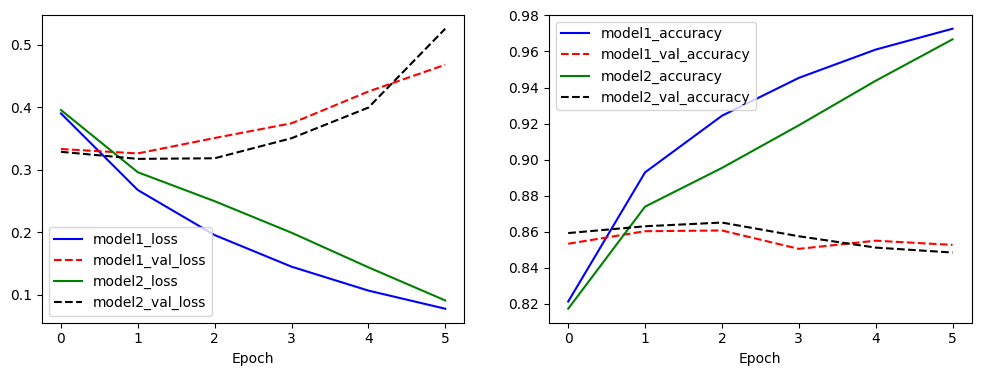

In [19]:
import matplotlib.pyplot as plt

# 손실 함수 값 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], 'b-', label='model1_loss')
plt.plot(history1.history['val_loss'], 'r--', label='model1_val_loss')
plt.plot(history2.history['loss'], 'g-', label='model2_loss')
plt.plot(history2.history['val_loss'], 'k--', label='model2_val_loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], 'b-', label='model1_accuracy')
plt.plot(history1.history['val_accuracy'], 'r--', label='model1_val_accuracy')
plt.plot(history2.history['accuracy'], 'g-', label='model2_accuracy')
plt.plot(history2.history['val_accuracy'], 'k--', label='model2_val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


## 실험3: SentencePiece의 모드를 BPE로 바꿔보자

결과가 마음에 안든다.

BPE를 적용해보자.

### 데이터 전처리 대충...

In [20]:
# 데이터 준비
train_data = orig_train.copy()
test_data = orig_test.copy()

# 대충 위에서 이미 결측치를 확인 했기 때문에 그대로 진행
train_data = train_data.dropna()
test_data = test_data.dropna()

In [22]:
with open('nsmc_text_bpe.txt', 'w', encoding='utf-8') as f:
    for line in train_data['document'].values:
        f.write(line + '\n')

input_fime = 'nsmc_text_bpe.txt'
vocab_size = 8000
prefix = 'korean_spm_bpe'

templates = '--input={} --model_prefix={} --vocab_size={} --model_type=bpe'
cmd = templates.format(input_fime, prefix, vocab_size)

spm.SentencePieceTrainer.Train(cmd)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=nsmc_text_bpe.txt --model_prefix=korean_spm_bpe --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_text_bpe.txt
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_

In [23]:
# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

for t in train_data.document.values[:5]:
    print(t)
    print(sp.EncodeAsPieces(t))
    print(sp.EncodeAsIds(t))
    print()


아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
[7, 1077, 3, 54, 2392, 40, 2103]

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
[1606, 8, 4992, 166, 1293, 4, 6507, 30, 6362, 6475, 273, 1712, 1920, 6294, 67, 412]

너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']
[24, 6322, 7909, 113, 3900, 408, 1232, 1826, 281]

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁교', '도', '소', '▁이야기', '구', '먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
[600, 6299, 6391, 291, 6386, 6793, 400, 4341, 1439, 236, 3, 1040, 135, 6331]

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['▁사이', '몬', '페', '그', '의', '▁익', '살', '스런', '▁연기가', '▁돋보', '였던', '▁영화', '!', '스', '파이', '더맨', '에서', '▁늙', '어', '보이', '기만', '▁했던', '▁커', '스', '틴', '▁던', '스트', '가', '▁너무나도', '▁이', '뻐', '보', '였다']
[2619, 7130, 6881, 6323, 6307, 3146, 6505, 1904, 663, 1690, 2191, 5, 6316, 6325, 1821, 5661, 47, 2314, 

In [24]:
# 텍스트 데이터 토큰화
train_data['document'] = train_data['document'].apply(sp.EncodeAsPieces)
test_data['document'] = test_data['document'].apply(sp.EncodeAsPieces)

In [25]:
# 토큰화된 데이터를 숫자로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])

In [26]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin')

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/2893645305.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_45498/2893645305.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 모델 구성 및 학습

In [27]:
# 모델 정의
model3 = Sequential()
model3.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model3.add(LSTM(128))
model3.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc3 = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history3 = model3.fit(train_inputs, train_labels, epochs=15, callbacks=[es3, mc3], batch_size=60, validation_split=0.2)


Epoch 1/15
2000/2000 [==============================] - 160s 78ms/step - loss: 0.3946 - accuracy: 0.8176 - val_loss: 0.3341 - val_accuracy: 0.8564
Epoch 2/15
2000/2000 [==============================] - 138s 69ms/step - loss: 0.2961 - accuracy: 0.8739 - val_loss: 0.3151 - val_accuracy: 0.8645
Epoch 3/15
2000/2000 [==============================] - 138s 69ms/step - loss: 0.2480 - accuracy: 0.8962 - val_loss: 0.3244 - val_accuracy: 0.8651
Epoch 4/15
2000/2000 [==============================] - 141s 70ms/step - loss: 0.1976 - accuracy: 0.9192 - val_loss: 0.3510 - val_accuracy: 0.8608
Epoch 5/15
2000/2000 [==============================] - 138s 69ms/step - loss: 0.1418 - accuracy: 0.9445 - val_loss: 0.4172 - val_accuracy: 0.8546
Epoch 6/15
2000/2000 [==============================] - 137s 69ms/step - loss: 0.0903 - accuracy: 0.9669 - val_loss: 0.5215 - val_accuracy: 0.8529
Epoch 6: early stopping


In [28]:
# 모델 평가
print(model3.evaluate(test_inputs, test_labels))


1563/1563 [==============================] - 22s 14ms/step - loss: 0.5362 - accuracy: 0.8485
[0.536237359046936, 0.8484908938407898]


### 시각화

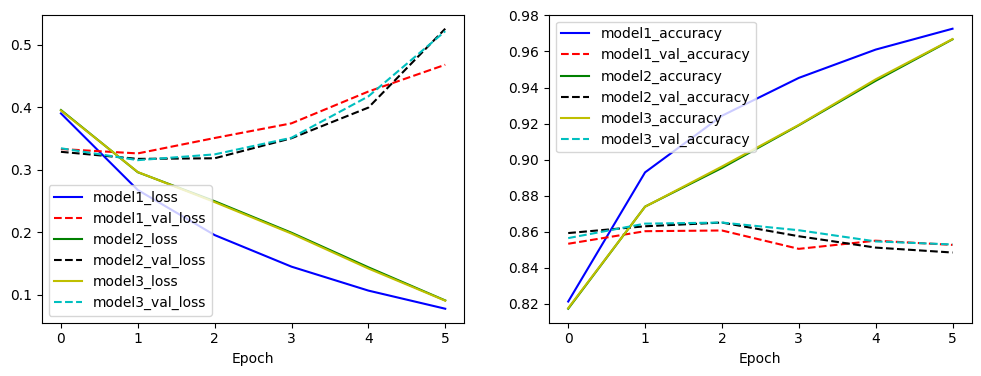

In [29]:
import matplotlib.pyplot as plt

# 손실 함수 값 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], 'b-', label='model1_loss')
plt.plot(history1.history['val_loss'], 'r--', label='model1_val_loss')
plt.plot(history2.history['loss'], 'g-', label='model2_loss')
plt.plot(history2.history['val_loss'], 'k--', label='model2_val_loss')
plt.plot(history3.history['loss'], 'y-', label='model3_loss')
plt.plot(history3.history['val_loss'], 'c--', label='model3_val_loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], 'b-', label='model1_accuracy')
plt.plot(history1.history['val_accuracy'], 'r--', label='model1_val_accuracy')
plt.plot(history2.history['accuracy'], 'g-', label='model2_accuracy')
plt.plot(history2.history['val_accuracy'], 'k--', label='model2_val_accuracy')
plt.plot(history3.history['accuracy'], 'y-', label='model3_accuracy')
plt.plot(history3.history['val_accuracy'], 'c--', label='model3_val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


## 결론

가장 먼저 SentencePiece 사용시 기반 모델로 작성한 첫번째 모델보다 좋은 성적을 보여주지 못했다.  
그리고 SentencePiece 모델을 사용한 모델2와 모델3를 비교했을 때, 큰 차이는 보이지 않지만, BPE를 사용했을 때, 유니그램 대비 좀 더 좋은 성과를 보여준다.  
하지만, 평가 수치로 봤을 때, 형태소 분석기와 사전 처리된 Word2Vec 모델을 사용한 모델1이 가장 좋은 성과를 보여준다.  

다만, 토크나이징 전에 데이터를 좀 더 정제하고, 불용어를 제거하면 성능이 더 좋아질 것으로 보인다.

